In [26]:
# Import the modules
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sympy as sy
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import optimize
# we will use the optimizer

# few elements
D = lambda L: [(np.array([[1, L],[0, 1]]), L)]
Q = lambda f: [(np.array([[1, 0],[-1/f, 1]]), 0)]


# few useful function

def compress_beamline(my_beamline, dimension=2):
    M=np.eye(dimension)
    s=0
    for i in my_beamline:
        M=i[0] @ M
        s=s+i[1]
    return [(M,s)]   

def R2beta(R):
    mu=np.arccos(0.5*(R[0,0]+R[1,1]))
    if (R[0,1]<0): 
        mu=2*np.pi-mu;
    Q=mu/(2*np.pi)
    beta=R[0,1]/np.sin(mu)
    alpha=(0.5*(R[0,0]-R[1,1]))/np.sin(mu)
    gamma=(1+alpha**2)/beta
    return (Q, beta, alpha, gamma)

---
# Adding thick quadrupoles and bending magnet

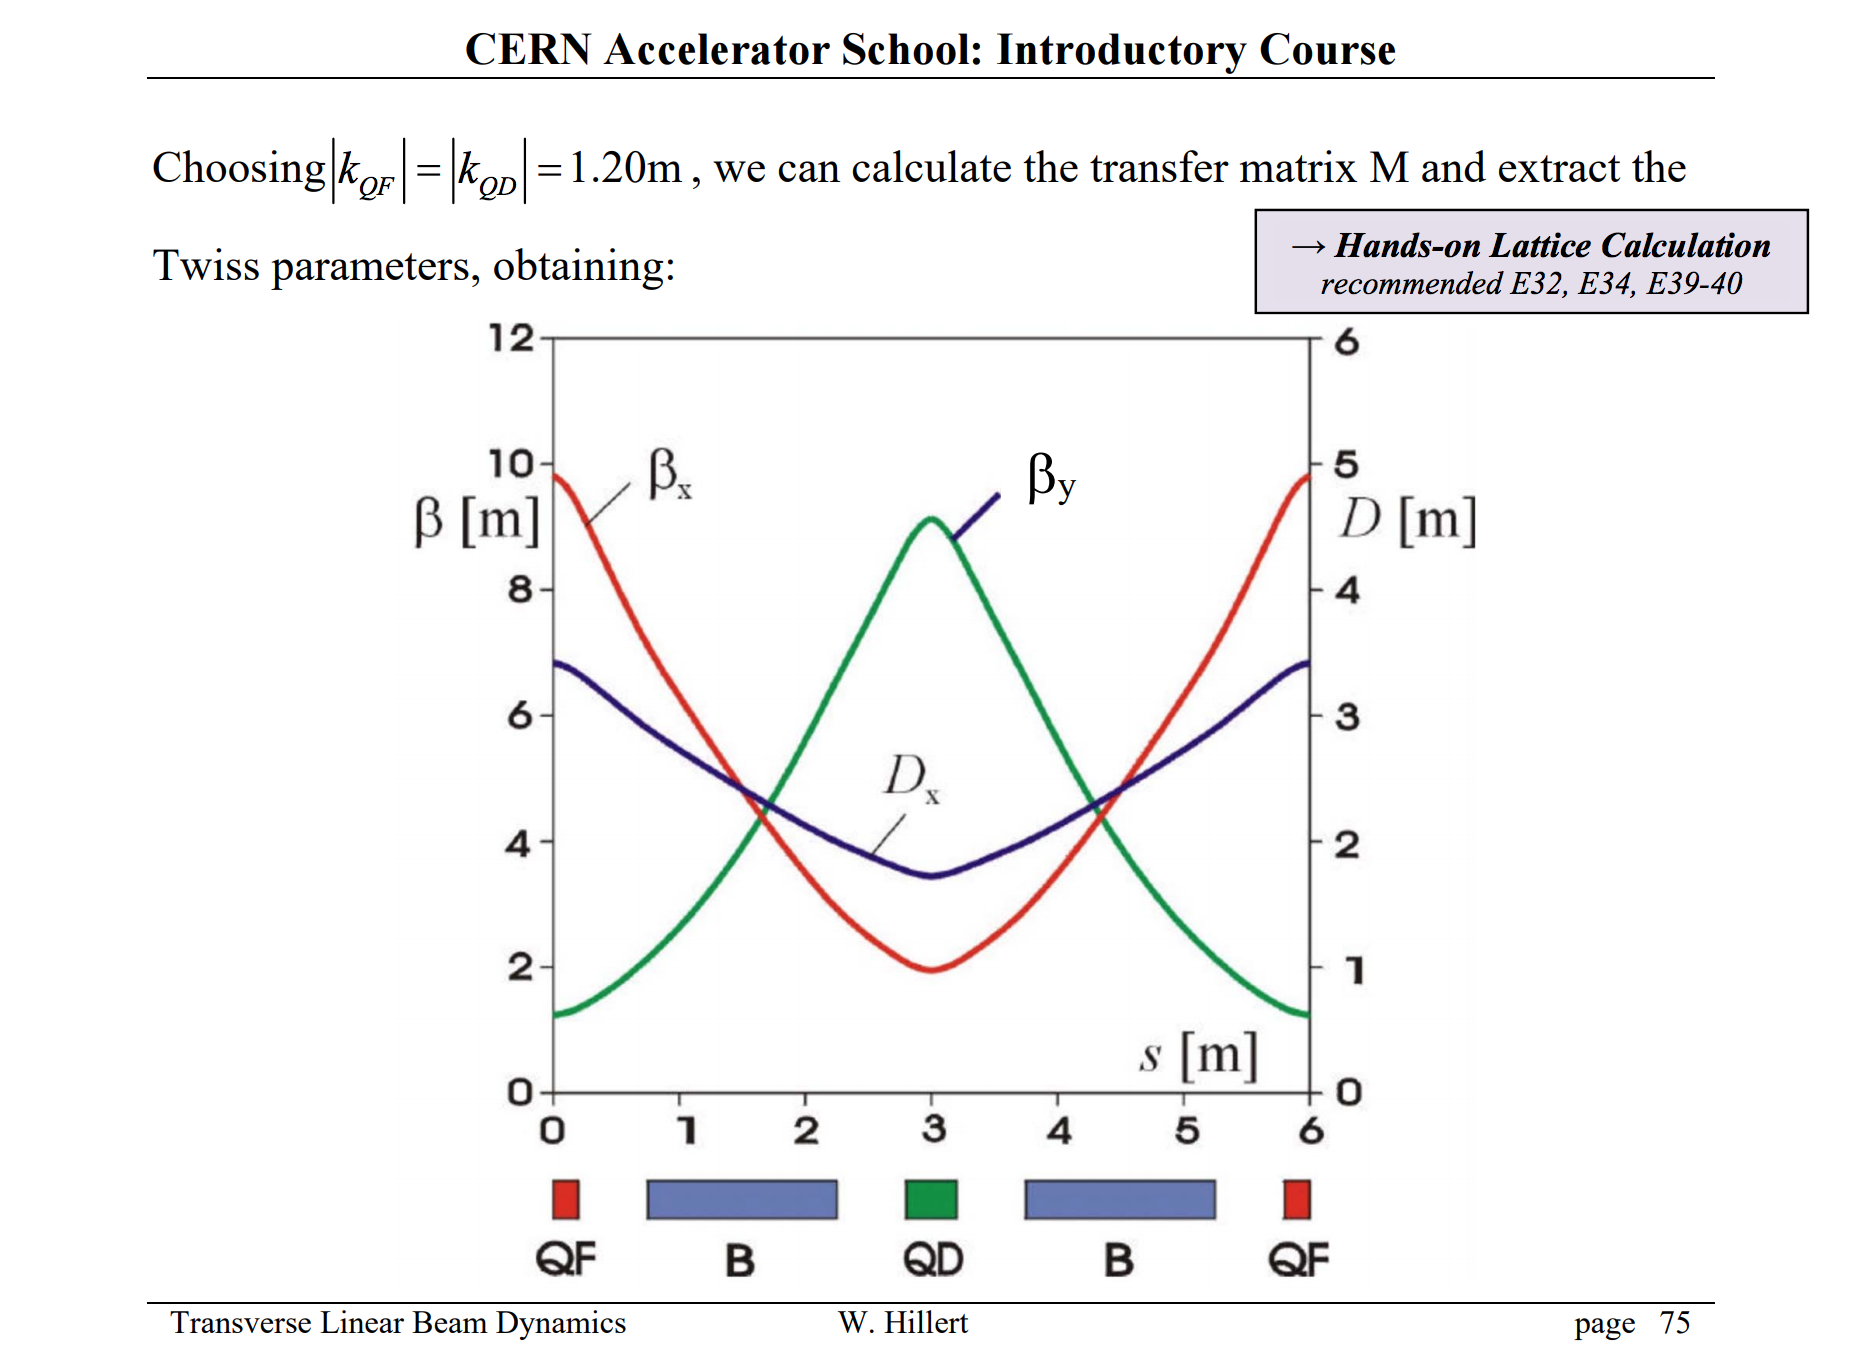

In [27]:
# Refer to 
from IPython.display import Image
fig = Image(filename=('/Users/sterbini/CERNBox/2019/CAS/Vysoke_Tatry/Python/Saturday/pag75.png'))
fig

---
# Exercise 29 

Introduce as a new element the **thick quadrupoles matrices**.
Hint:  write an external function that returns the corresponding list of tuple.
### SOLUTION

In [28]:
def Qthick(k1, l):
    if k1>0:
        matrix=np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l)]])
    else:
        k1=-k1;
        matrix=np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l)]])
    return [(matrix, l)]

---
# Exercise 30

Use the beam line from Exercise 27 (60 degrees/cell FODO) and **replace the thin quadrupoles by long quadrupoles** with a length of 0.2, 0.4, 1.0 m.  Make sure the overall length and the phase advance of the FODO cell remains unchanged. By how much does the periodic beta function at the start of the cell change? Express the change in percent. 

### SOLUTION

In [127]:
# Thin lens
f=2
L_2=2
fodo_lattice= Q(f)+10*D(L_2/10)+Q(-f)+10*D(L_2/(10))
OTM=compress_beamline(fodo_lattice)
(tune, beta, alpha, gamma)=R2beta(OTM[0][0])
beta_thin=beta

def penaltyFunction(f,l_quad):
    l_cell=4 
    l_drift=(l_cell-2*l_quad)/2
    k1=1/f/l_quad
    fodo_lattice= Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    OTM=compress_beamline(fodo_lattice)
    (tune, beta, alpha, gamma)=R2beta(OTM[0][0])
    return np.abs(tune-1/6)


# Thick lenses
for l_quad in [.0001,.1,.2,.6,1.0]:
    def penaltyFunctionSpecial(myF):
        return penaltyFunction(myF[0],l_quad)
    opt=optimize.minimize(penaltyFunctionSpecial,[1])
    f=opt.x[0]
    l_cell=4 
    l_drift=(l_cell-2*l_quad)/2
    k1=1/f/l_quad
    fodo_lattice= Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    OTM=compress_beamline(fodo_lattice)
    (tune, beta, alpha, gamma)=R2beta(OTM[0][0])
    print('%%%%%%%%%%%%%%%%%%')
    print(f'tune {tune}')
    print(f'With l_quad={l_quad} m we have a relative error if we assume thin lens approximation of {(beta-beta_thin)/beta_thin}!')

%%%%%%%%%%%%%%%%%%
tune 0.16666666678066833
With l_quad=0.0001 m we have a relative error if we assume thin lens approximation of -1.6666942896765395e-05!
%%%%%%%%%%%%%%%%%%
tune 0.16666666701409083
With l_quad=0.1 m we have a relative error if we assume thin lens approximation of -0.016738288493791657!
%%%%%%%%%%%%%%%%%%
tune 0.16666666737527677
With l_quad=0.2 m we have a relative error if we assume thin lens approximation of -0.03362903785324495!
%%%%%%%%%%%%%%%%%%
tune 0.1666666669912484
With l_quad=0.6 m we have a relative error if we assume thin lens approximation of -0.10304866427089407!
%%%%%%%%%%%%%%%%%%
tune 0.1666666672771789
With l_quad=1.0 m we have a relative error if we assume thin lens approximation of -0.17654634320934862!


---
# Exercise 31

Program the element corresponding to the **weak focusing of a sector bend** (see the [Primer](https://indico.cern.ch/event/808940/contributions/3553546/attachments/1904762/3145489/CAS_Optics_Primer.pdf)). 

### SOLUTION

In [30]:
sin=np.sin
cos=np.cos
B= lambda phi, l: [(np.array([[cos(phi),l/phi*sin(phi)],[-sin(phi)/l*phi, cos(phi)]]),l)]
B(.001,1)

[(array([[ 9.99999500e-01,  9.99999833e-01],
         [-9.99999833e-07,  9.99999500e-01]]), 1)]

**NB**: Please note that this almost equivalent to D(1)!

---
# Exercise 32
**Insert 1 m long dipoles** in the center of the drift spaces of the FODO cells from Exercise 27 while keeping the length of the cell constant. Investigate deflection angles of φ= 5, 10 and 20 degrees.  Check by how much the periodic beta functions change.  Why do they change?  Explain!  Can you compensate the phase advance $\mu$ by adjusting the strength or focal lengths of the quadrupoles?

### SOLUTION 


In [31]:
# Thin lens and  dipoles

for phi in np.array([5,10,20])*np.pi/180:
    
    f=2
    l_cell=4
    l_dipole=1
    l_drift=(l_cell-l_dipole*2)/4
    fodo_lattice= Q(f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)+Q(-f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)
    OTM=compress_beamline(fodo_lattice)
    (tune, beta, alpha, gamma)=R2beta(OTM[0][0])
    print('%%%%%%%%%%%%%%%%%%')
    print(f'tune {tune}')
    print(f'With phi={phi} m we have a relative error of {(beta-beta_thin)/beta_thin}!')

%%%%%%%%%%%%%%%%%%
tune 0.1715557781965092
With phi=0.08726646259971647 m we have a relative error of -0.026504367134691145!
%%%%%%%%%%%%%%%%%%
tune 0.185496939857327
With phi=0.17453292519943295 m we have a relative error of -0.09386135560192699!
%%%%%%%%%%%%%%%%%%
tune 0.2336669617433714
With phi=0.3490658503988659 m we have a relative error of -0.25835857726299966!


In [47]:
# Thin lens and  dipoles with matching
f=2
L_2=2
pi=np.pi
fodo_lattice= Q(f)+10*D(L_2/10)+Q(-f)+10*D(L_2/(10))
OTM=compress_beamline(fodo_lattice)
(tune, beta, alpha, gamma)=R2beta(OTM[0][0])
beta_thin=beta

# Thin lens and  dipoles

from scipy import optimize
def penaltyFunction(f,phi):
    l_cell=4
    l_dipole=1
    l_drift=(l_cell-l_dipole*2)/4
    fodo_lattice= Q(f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)+Q(-f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)
    OTM=compress_beamline(fodo_lattice)
    (tune, beta, alpha, gamma)=R2beta(OTM[0][0])
    return np.abs(tune-1/6)

for phi in np.array([5,10,20])*pi/180:
    def penaltyFunctionSpecial(myF):
        return penaltyFunction(myF[0],phi)
    opt=optimize.minimize(penaltyFunctionSpecial,[2])
    f=opt['x'][0]
    l_cell=4
    l_dipole=1
    l_drift=(l_cell-l_dipole*2)/4
    fodo_lattice= Q(f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)+Q(-f)+D(l_drift)+B(phi,l_dipole)+D(l_drift)
    OTM=compress_beamline(fodo_lattice)
    (tune, beta, alpha, gamma)=R2beta(OTM[0][0])
    print('%%%%%%%%%%%%%%%%%%')
    print(f'tune {tune}')
    print(f'With phi={phi} m we have a relative error of {(beta-beta_thin)/beta_thin}!')

%%%%%%%%%%%%%%%%%%
tune 0.16666666724939802
With phi=0.08726646259971647 m we have a relative error of -0.018770066252134964!
%%%%%%%%%%%%%%%%%%
tune 0.16666666712749836
With phi=0.17453292519943295 m we have a relative error of -0.0758406594175982!
%%%%%%%%%%%%%%%%%%
tune 0.16666666668875768
With phi=0.3490658503988659 m we have a relative error of -0.34731267978925245!


---
# From 2x2 to 3x3 matrices

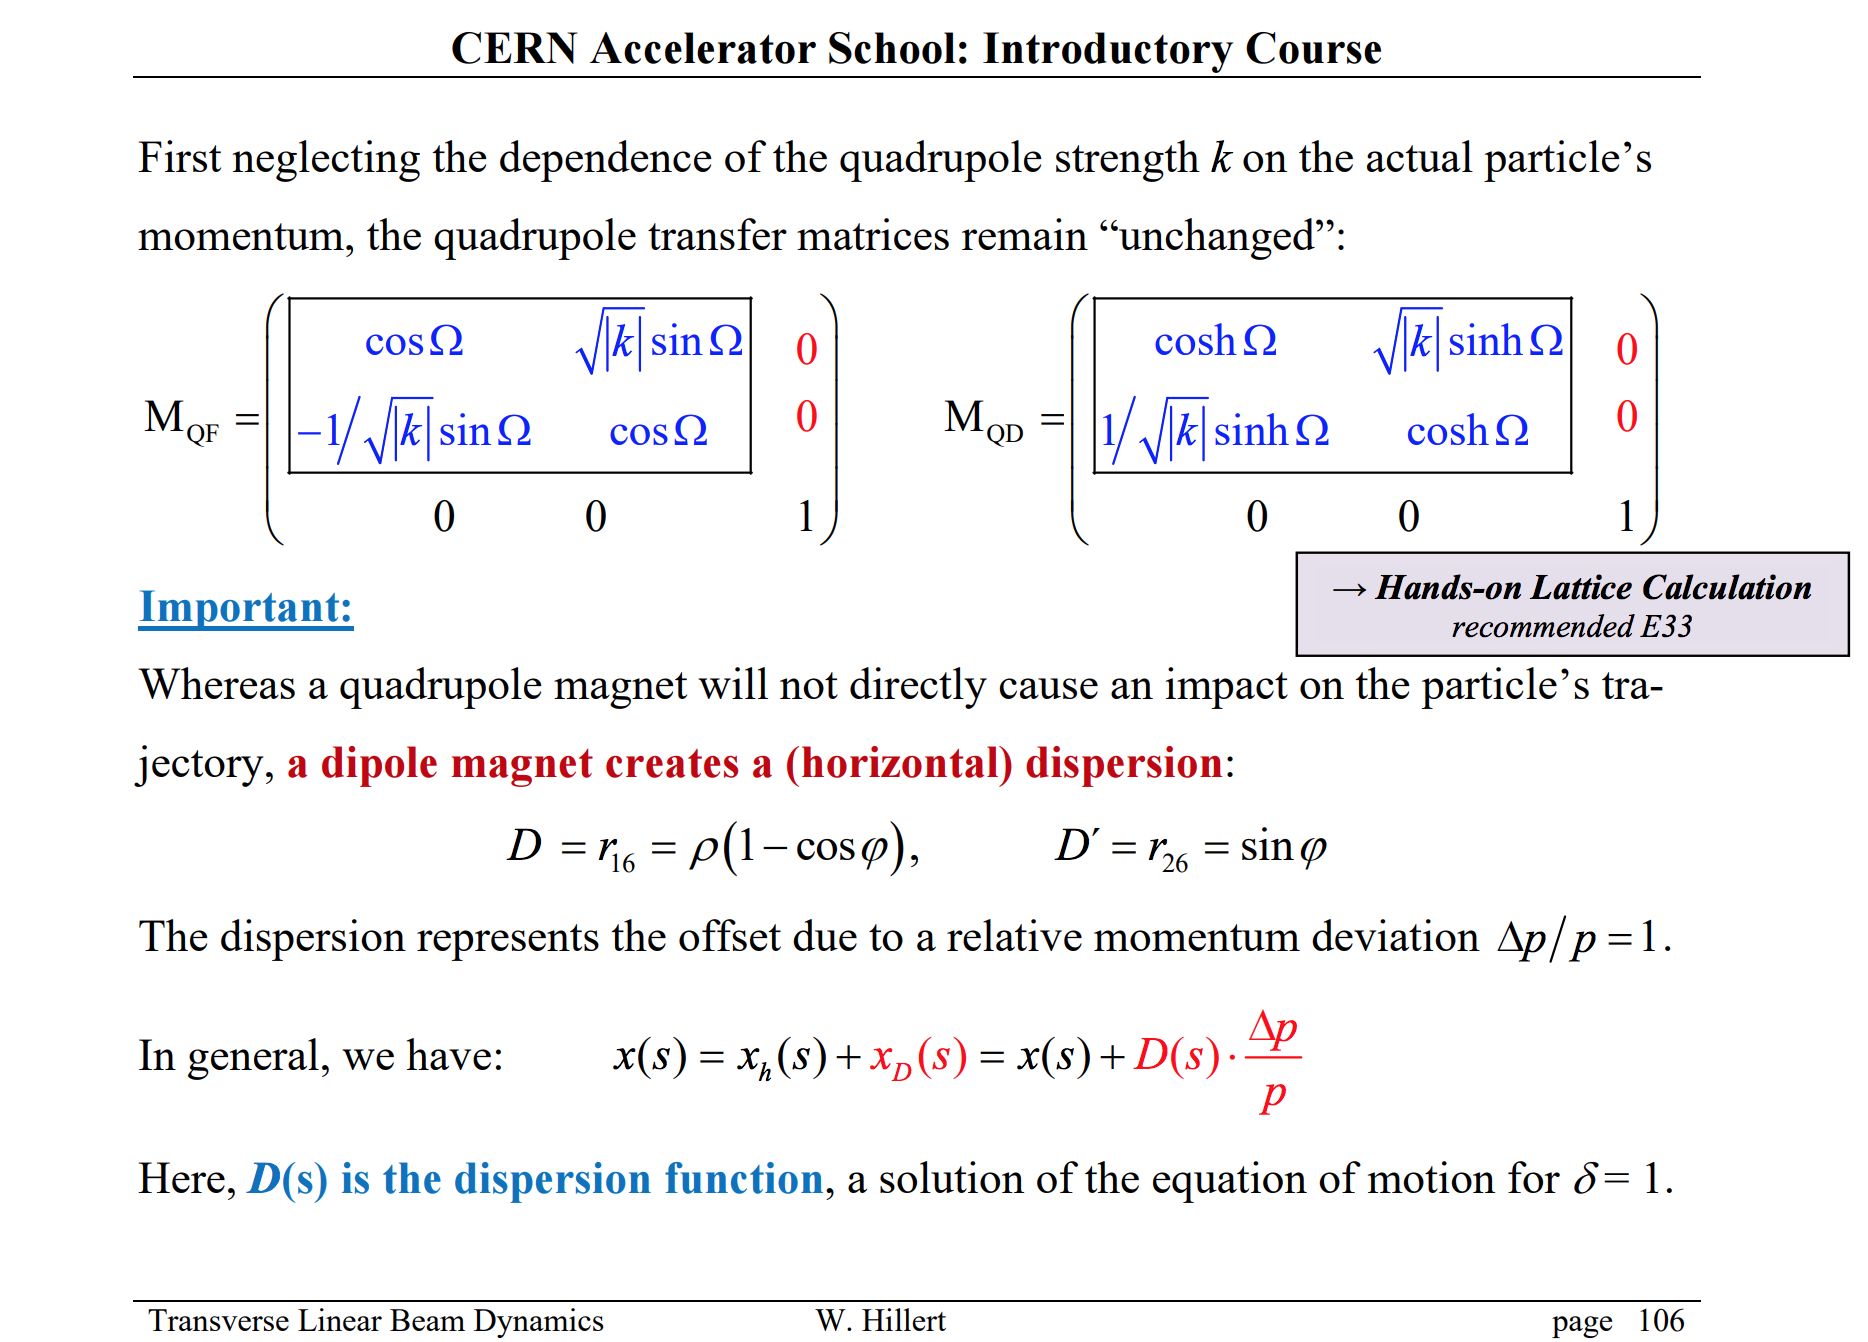

In [22]:
# Refer to 
from IPython.display import Image
fig = Image(filename=('/Users/sterbini/CERNBox/2019/CAS/Vysoke_Tatry/Python/Saturday/pag106.png'))
fig

---
# Exercise 33
**Upgrade the software to consistently handle $3\times3$ matrices** for drift space, quadrupoles, and sector dipoles.

### SOLUTION 

In [32]:
def Qthick3(k1, l):
    if k1>0:
        matrix=np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    else:
        k1=-k1;
        matrix=np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    return [(matrix, l)]

In [33]:
# The drift as a sequence of a single tuple
D3 = lambda L: [(np.array([[1, L, 0],[0, 1, 0], [0, 0, 1]]), L)]

# The quadrupole as a sequence of a single tuple
Q3 = lambda f: [(np.array([[1, 0, 0],[-1/f, 1,0],[0,0,1]]), 0)]

# The sector bend
B3= lambda phi, l: [(np.array([[cos(phi),l/phi*sin(phi), l/phi*(1-cos(phi))],\
                              [-sin(phi)/l*phi, cos(phi), sin(phi)],
                             [0,0,1]]),l)]

def R2beta(R):
    # 2x2 case
    if np.shape(R)[0]==2:
        mu=np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu=2*np.pi-mu;
        Q=mu/(2*np.pi)
        beta=R[0,1]/np.sin(mu)
        alpha=(0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma=(1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 3x3 case
    if np.shape(R)[0]==3:
        R=R[:3,:3]
        mu=np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu=2*np.pi-mu;
        Q=mu/(2*np.pi)
        beta=R[0,1]/np.sin(mu)
        alpha=(0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma=(1+alpha**2)/beta
        return (Q, beta, alpha, gamma)

R2beta(OTM[0][0])

(0.2336669617433714, 5.138242500712612, -1.284560625178153, 0.5157592307857309)

# About dispersion

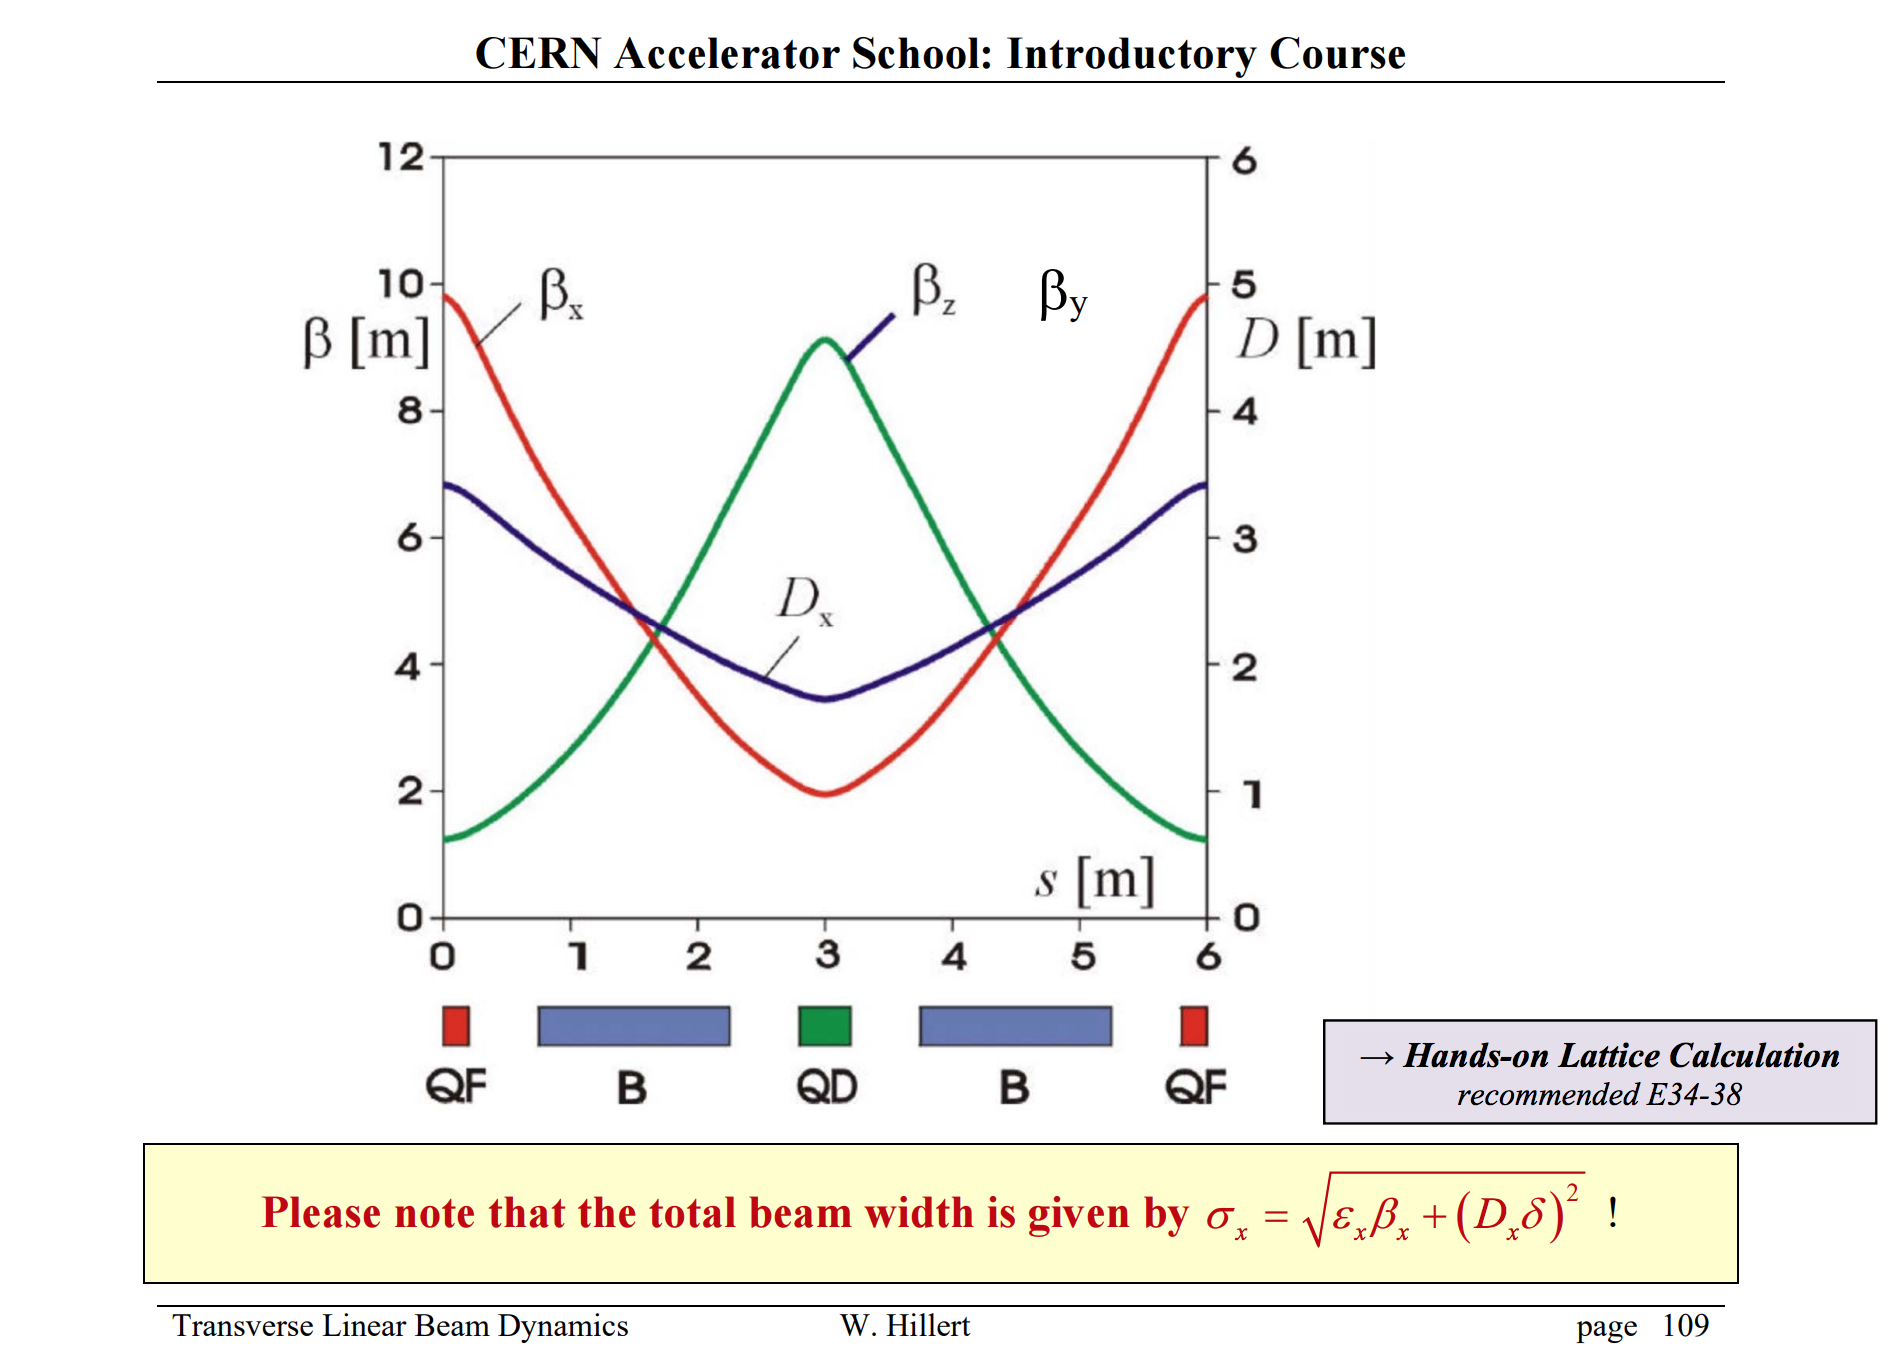

In [34]:
# Refer to 
from IPython.display import Image
fig = Image(filename=('/Users/sterbini/CERNBox/2019/CAS/Vysoke_Tatry/Python/Saturday/pag109.png'))
fig

---
# Exercise 34
Build a beam line of six FODO cells with a phase advance of 60 degrees/cell (thin quadrupoles are OK to use) and add a sector bending magnet with length 1 m and bending angle $\phi=10$ degrees in the center of each drift. You may have to play with the quadrupole values to make the phase advance close to 60 degrees. But you probably already did this in Exercise 32.

### SOLUTION

In [48]:
f=2.26085
l_cell=4
l_dipole=1
l_drift=(l_cell-l_dipole*2)/4
phi=20*pi/360
fodo_lattice= Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)

In [54]:
OTM=compress_beamline(fodo_lattice,dimension=3)
(tune, beta, alpha, gamma)=R2beta(OTM[0][0])
print(f'''tune: {tune}
beta: {beta} m
alpha: {alpha}
gamma: {gamma}
''')

tune: 0.16666742254599537
beta: 6.402756913976356 m
alpha: -1.4160065714170236
gamma: 0.46934073098051265



In [55]:
beamline=6*fodo_lattice

---
# Exercise 35
Use the starting conditions $(x_0,x_0',\delta)=(0,0,0)$ and plot the position along the beam line. **Repeat this for $\delta=10^{-3}$ and for $\delta=3\times 10^{-3}$**. Plot all three traces in the same graph. Discuss what you observe and explain!

### SOLUTION

Text(0, 0.5, 'x [mm]')

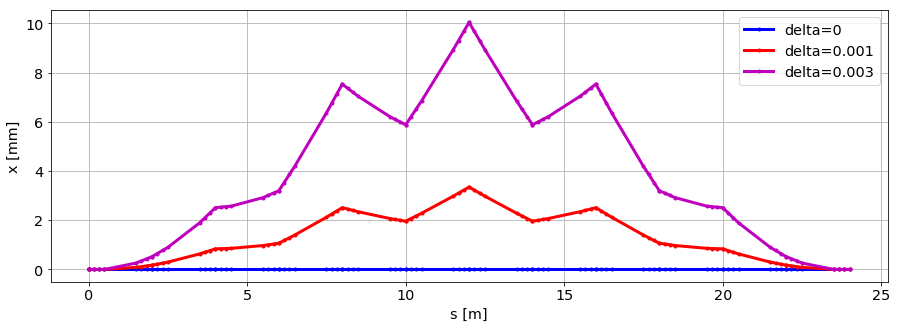

In [56]:
# tracking
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
for delta,color in zip([0,1e-3, 3e-3],['b','r','m']):
    beamlist=[(np.array([[0],[0],[delta]]),0)]
    for element in beamline:
        beamlist.append((element[0] @ beamlist[-1][0],beamlist[-1][1]+ element[1]))
    plt.plot([x[1] for x in beamlist],[x[0][0]*1e3 for x in beamlist],'.-'+color, label=f'delta={delta}', lw=3)
plt.legend()
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

---
# Exercise 36
Work out the transverse components of the periodic beam matrix $\sigma_0$. Assume that the emittance is $\epsilon_0=10^{-6}$ meter-rad. Furthermore, assume that the momentum spread $\sigma_0(3,3)=\sigma_p^2$ is zero and plot the **beam size**.

### SOLUTION

In [61]:
epsilon_0=1e-6
sigma_p_2=0
sigma_0=epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2]])

Text(0.5, 0, 's [m]')

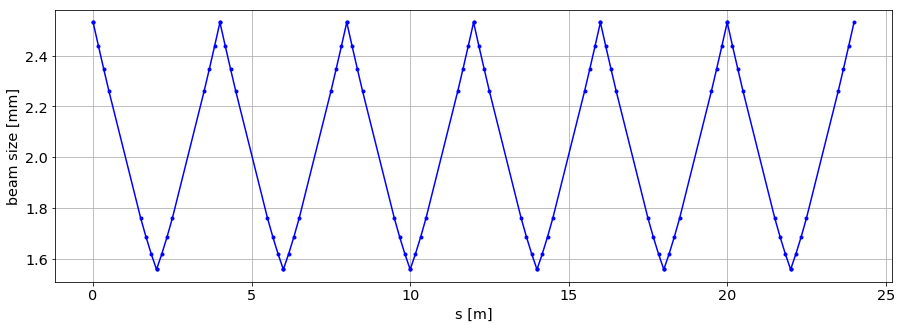

In [63]:
sigma_list=[(sigma_0,0)];
for element in beamline:
    sigma_list.append((element[0]@sigma_list[-1][0]@(element[0].transpose()),sigma_list[-1][1]+element[1]))

plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][0,0])*1000 for i in sigma_list],'.-b')

plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

---
# Exercise 37
Plot the beam size for for $\sigma_p^2=10^{-3}$ and for $\sigma_p^2=3\times 10^{-3}$. What happens if you change the phase advance of the cell? Try out by slightly changing the focal lengths.

### SOLUTION

Text(0.5, 0, 's [m]')

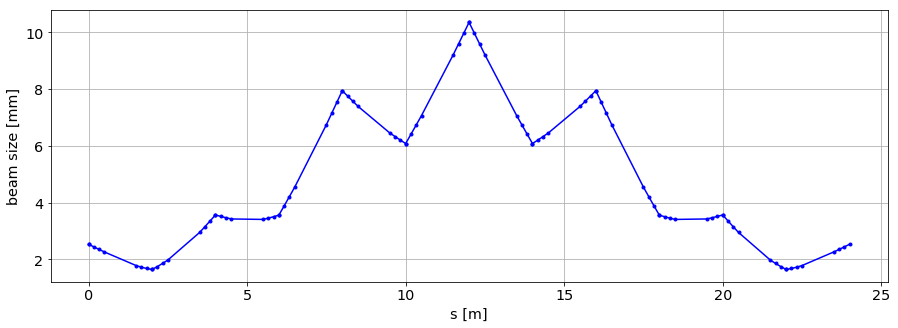

In [68]:
f=2.26085
#f=1.8

l_cell=4
l_dipole=1
l_drift=(l_cell-l_dipole*2)/4
phi=20*pi/360
fodo_lattice= Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)
beamline=6*fodo_lattice

sigma_p_2=(3e-3)**2*1

OTM=compress_beamline(fodo_lattice, dimension=3)
(tune, beta, alpha, gamma)=R2beta(OTM[0][0])

sigma_0=epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2/epsilon_0]])
sigma_list=[(sigma_0,0)];
for element in beamline:
    sigma_list.append((element[0]@sigma_list[-1][0]@(element[0].transpose()),sigma_list[-1][1]+element[1]))

plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][0,0])*1000 for i in sigma_list],'.-b',label='$\\beta_x\ [m]$')

plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

---
# Exercise 38: IMPORTANT, periodic dispersion

Determine the periodic dispersion at the start of the cell. Then plot the dispersion in the cell.

### SOLUTION

For that we need to solve the problem 

\begin{equation}
M_{OTM}\times D=D
\end{equation}


In [73]:
eigenvalues, eigenvectors =np.linalg.eig(OTM[0][0])

In [74]:
eigenvalues

array([0.49999589+0.86602778j, 0.49999589-0.86602778j,
       1.        +0.j        ])

In [75]:
eigenvectors

array([[0.96524786+0.j        , 0.96524786-0.j        ,
        0.84331413+0.j        ],
       [0.21347012+0.15075504j, 0.21347012-0.15075504j,
        0.18650378+0.j        ],
       [0.        +0.j        , 0.        -0.j        ,
        0.50402145+0.j        ]])

In [77]:
myDispersion=eigenvectors[:,2]/eigenvectors[2,2]
myDispersion

array([1.67317109+0.j, 0.37003142+0.j, 1.        +0.j])

In [72]:
OTM[0][0]@myDispersion

array([1.67317109+0.j, 0.37003142+0.j, 1.        +0.j])

---
# Exercise 39
Convert the code to use $4\times4$ matrices, where the third and fourth columns are associated with the vertical plane. 

### SOLUTION

In [80]:
def Qthick4(k1, l):
    if k1>0:
        matrix=np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0,0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0, 0],\
                         [0,0,np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],\
                         [0,0,np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l)],\
                        ])
    else:
        k1=-k1;
        matrix=np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0,0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0,0],\
                         [0,0,np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],\
                         [0,0,-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l)],\
                         ])
    return [(matrix, l)]


# The drift as a sequence of a single tuple
D4 = lambda L: [(np.array([[1, L, 0, 0],[0, 1, 0, 0], [0, 0, 1, L], [0, 0, 0, 1]]), L)]

# The quadrupole as a sequence of a single tuple
Q4 = lambda f: [(np.array([[1, 0, 0, 0],[-1/f, 1, 0, 0],[0, 0, 1, 0],[0, 0, 1/f, 1]]), 0)]

# The sector bend
B4= lambda phi, l: [(np.array([[cos(phi),l/phi*sin(phi), 0, 0],\
                               [-sin(phi)/l*phi, cos(phi), 0, 0],\
                               [0, 0, 1, l],
                               [0, 0, 0, 1]]),l)]

def R2beta(R):
    # 2x2 case
    if np.shape(R)[0]==2:
        mu=np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu=2*np.pi-mu;
        Q=mu/(2*np.pi)
        beta=R[0,1]/np.sin(mu)
        alpha=(0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma=(1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 3x3 case
    if np.shape(R)[0]==3:
        R=R[:3,:3]
        mu=np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu=2*np.pi-mu;
        Q=mu/(2*np.pi)
        beta=R[0,1]/np.sin(mu)
        alpha=(0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma=(1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 4x4 case, we assume uncoupled motion!!!
    if np.shape(R)[0]==4:
    
        Rx=R[:2,:2]
        mux=np.arccos(0.5*(Rx[0,0]+Rx[1,1]))
        if (Rx[0,1]<0): 
            mux=2*np.pi-mux;
        Qx=mux/(2*np.pi)
        betax=Rx[0,1]/np.sin(mux)
        alphax=(0.5*(Rx[0,0]-Rx[1,1]))/np.sin(mux)
        gammax=(1+alphax**2)/betax
        
        Ry=R[2:,2:]
        muy=np.arccos(0.5*(Ry[0,0]+Ry[1,1]))
        if (Ry[0,1]<0): 
            muy=2*np.pi-muy;
        Qy=muy/(2*np.pi)
        betay=Ry[0,1]/np.sin(muy)
        alphay=(0.5*(Ry[0,0]-Ry[1,1]))/np.sin(muy)
        gammay=(1+alphay**2)/betay
        
        return (Qx, betax, alphax, gammax, Qy, betay, alphay, gammay)

    
# Test
f=2.
l_cell=4
l_drift=(l_cell)/2
fodo_lattice= Q4(f)+10*D4(l_drift/10)+Q4(-f)+10*D4(l_drift/10)
OTM=compress_beamline(fodo_lattice, dimension=4)
R2beta(OTM[0][0])

(0.16666666666666663,
 6.928203230275511,
 -1.7320508075688774,
 0.5773502691896256,
 0.16666666666666666,
 2.309401076758503,
 0.5773502691896257,
 0.5773502691896257)

---
# Exercise 40
Start from a single FODO cell with 60 degrees/cell you used earlier. Insert sector bending magnets with a bending angle of $\phi=10\,$degrees in the center of the drift spaces. The bending magnets will spoil the phase advance in one plane. Now you have two phase advances and need to adjust both quadrupoles (by hand to 2 significant figures) such that it really is 60 degrees in both planes.

### SOLUTION

In [83]:
l_cell=4
l_dipole=1
l_drift=(l_cell-l_dipole*2)/4

def computeTunes(f_f,f_d):
    phi=10*pi/360
    fodo_lattice= Q4(f_f)+D4(l_drift)+B4(phi,l_dipole)+D4(l_drift)+Q4(f_d)+D4(l_drift)+B4(phi,l_dipole)+D4(l_drift)
    OTM=compress_beamline(fodo_lattice, dimension=4)
    Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = R2beta(OTM[0][0])
    print(f'Qx={Qx}')
    print(f'Qy={Qy}')
    print(f'f_f={f_f}')
    print(f'f_d={f_d}')

    
interactive_plot = interactive(computeTunes,f_f=(1.9,2.1,.001),f_d=(-2.1,-1.9,.001),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=2.1, min=1.9, step=0.001), FloatSlider(val…

In [84]:
computeTunes(2.04,-2.012)

Qx=0.16679597540775906
Qy=0.16683496767875342
f_f=2.04
f_d=-2.012


---
# Exercise 41

Use the result from exercise 40 and adjust the two quadrupoles such that the phase advance in the horizontal plane is 90 degrees, cell, while it remains 60 degrees/cell in the vertical plane. 
### SOLUTION

In [85]:
interactive_plot = interactive(computeTunes,f_f=(1.,3,.001),f_d=(-3,-1,.001),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=3.0, min=1.0, step=0.001), FloatSlider(val…

In [86]:
computeTunes(1.491,-1.814)

Qx=0.25013216769227664
Qy=0.16677964050295382
f_f=1.491
f_d=-1.814


---
# Exercise 42
Prepare a beam line with eight FODO cells without bending magnets and with 60 degrees/cell phase advance in both planes. (a) Prepare the periodic beam  matrix sigma0 (4x4, uncoupled) as the initial beam and plot both beam sizes along the beam line. (b) Use sigma0 as the starting beam, but change the focal length of the second quadrupole by 10\% and plot the beam sizes once again. Discuss you observations.

### SOLUTION

In [87]:
beamline[11]

(array([[1.        , 0.16666667, 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]), 0.16666666666666666)

Text(0.5, 0, 's [m]')

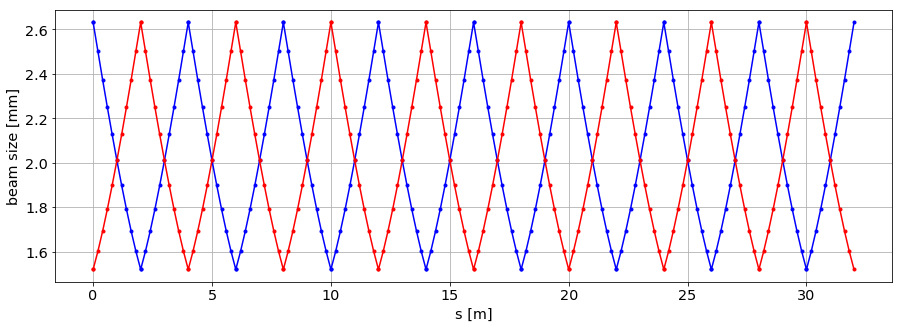

In [88]:
f=2.
l_cell=4
l_drift=(l_cell)/2
fodo_lattice= Q4(f)+10*D4(l_drift/10)+Q4(-f)+10*D4(l_drift/10)
beamline=8*fodo_lattice
OTM=compress_beamline(fodo_lattice, dimension=4)
R2beta(OTM[0][0])

(Qx, betax, alphax, gammax,Qy, betay, alphay, gammay)=R2beta(OTM[0][0])

epsilon_0=1e-6
sigma_0=epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],\
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],\
                 ])

sigma_list=[(sigma_0,0)];
for element in beamline:
    sigma_list.append((element[0]@sigma_list[-1][0]@(element[0].transpose()),sigma_list[-1][1]+element[1]))

plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][0,0])*1000 for i in sigma_list],'.-b',label='$\\beta_x\ [m]$')
plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][2,2])*1000 for i in sigma_list],'.-r',label='$\\beta_x\ [m]$')

plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

Text(0.5, 0, 's [m]')

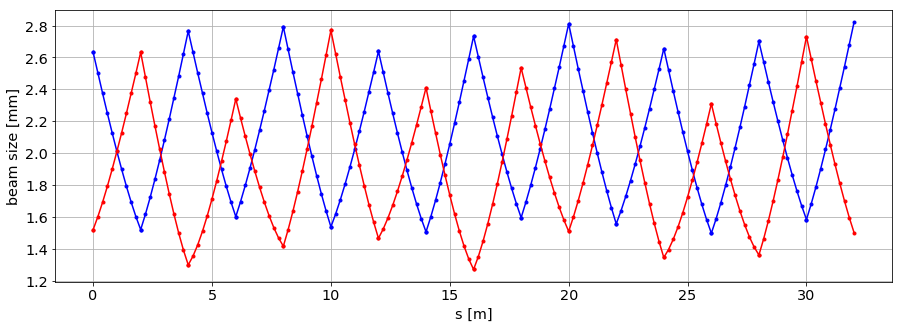

In [89]:
from copy import deepcopy
beamline_new=deepcopy(beamline)

# chaging the strength of the quadrupole in the two planes
beamline_new[11][0][1,0]=beamline_new[11][0][1,0]*1.1
beamline_new[11][0][3,2]=beamline_new[11][0][3,2]*1.1
sigma_list=[(sigma_0,0)];
for element in beamline_new:
    sigma_list.append((element[0]@sigma_list[-1][0]@(element[0].transpose()),sigma_list[-1][1]+element[1]))

plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][0,0])*1000 for i in sigma_list],'.-b',label='$\\beta_x\ [m]$')
plt.plot([i[1] for i in sigma_list], [np.sqrt(i[0][2,2])*1000 for i in sigma_list],'.-r',label='$\\beta_x\ [m]$')

plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

---
# Exercise 43
You learnt about coupling from Wolfgang's and Volker's lecture.
Extend the simulation code to handle solenoids. One has to know that the solenoid's matrix is
\begin{equation}
M_{\text {SOLENOID}}=\left(\begin{array}{cccc}{C^{2}} & {\frac{1}{K} S C} & {S C} & {\frac{1}{K} S^{2}}\\
{-K S C} & {C^{2}} & {-K S^{2}} & {S C}\\
{-S C} & {-\frac{1}{K} S^{2}} & {C^{2}} & {\frac{1}{K} S C}\\
{K S^{2}} & {-S C} & {-K S C} & {C^{2}}
\end{array}\right)
\end{equation}
where
\begin{equation}
K=\operatorname{sgn}(\mathrm{q}) \frac{B_{s}}{2(B \rho)}
\end{equation}
and
\begin{equation}
\begin{array}{l}{C=\cos K L} \\ {S=\sin K L}\end{array}
\end{equation}

Check the simplecticity of the matrix (assuming some given parameters, example: $B_s=0.2$ T, $L=1$ m, $B \rho$=0.1 Tm and $sgn(q)=1$).
Define a beam line where you place the solenoid in the middle of a FODO cell and follow a particle with initial condition $(x_0,x'_0,y_0,y'_0)=(1\times10^3\,\mathrm{m},0,0,0).$ What do you observe? Is the motion confined to the horizontal plane? 

### SOLUTION




In [121]:
def SOLENOID(Bs,L,B_rho,q):
    K=np.sign(q)*Bs/B_rho/2
    C=np.cos(K*L)
    S=np.sin(K*L)
    matrix=np.array([[C**2, S*C/K, S*C, S**2/K],
                     [-K*S*C, C**2, -K*S**2, S*C],
                     [-S*C, -S**2/K, C**2, S*C/K],
                     [K*S**2, -S*C, -K*S*C, C**2]])
    return [(matrix,L)]
    

# IMPORTANT: is it symplectic?

In [122]:
# Matrix definition
Omega=np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])
M=SOLENOID(.2,1,.1,1)[0][0]

# Sum and multiplication of matrices
np.max(np.abs(Omega - M.T @ Omega @ M))
# M.T means the "traspose of M".
# This is to verify that the matrix is symplectic.

2.220446049250313e-16

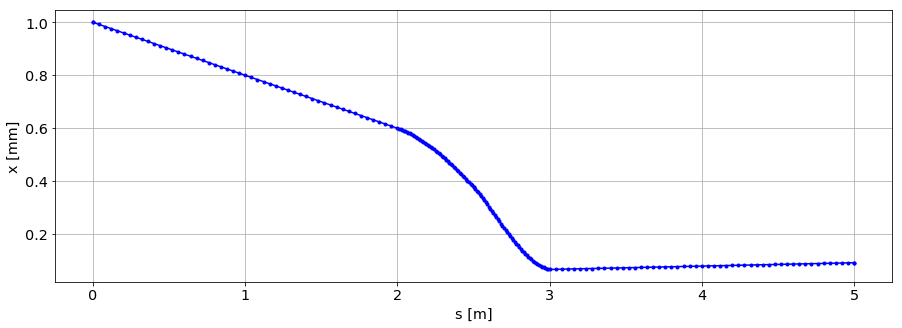

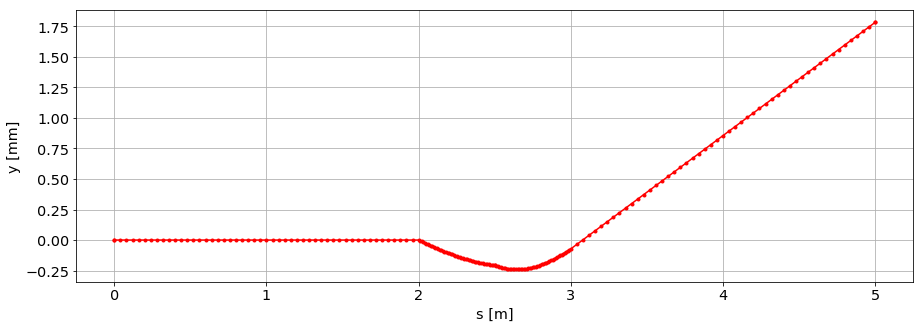

In [123]:
f=2.5
L_2=2
fodo_lattice= Q4(2*f)+50*D4(L_2/50)+50*SOLENOID(.2,.01,.1,1)+Q4(-f)+50*SOLENOID(.4,.01,.1,1)+50*D4(L_2/(50))+Q4(2*f)

beamlist=[(np.array([[1e-3],[0],[0],[0]]),0)]
for element in fodo_lattice:
    beamlist.append((element[0] @ beamlist[-1][0],beamlist[-1][1]+ element[1]))

plt.plot(np.array([x[1] for x in beamlist]),[x[0][0]*1000 for x in beamlist],'.-b')
plt.xlabel('s [m]')
plt.ylabel("x [mm]")

plt.grid(True)

plt.figure()
s=np.array([x[1] for x in beamlist])
y=[x[0][2]*1000 for x in beamlist]
plt.plot(s,y,'.-r')

plt.xlabel('s [m]')
plt.ylabel("y [mm]")
plt.grid(True)